In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=20000, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1667, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


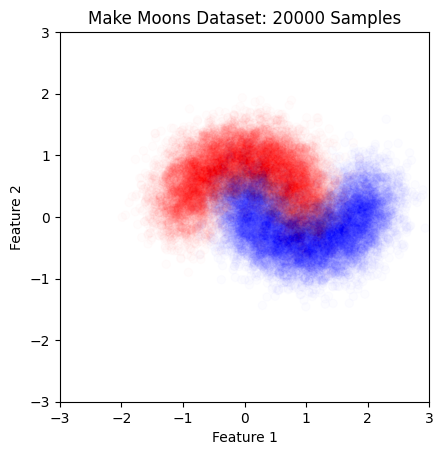

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


plt.figure(figsize=(8, 6))

update_interval = len(y) // 10  # Number of points to add in each update

for i in range(0, len(y) + 1, update_interval):
    clear_output(wait=True)
    # Ensure the last iteration includes all data points
    if i + update_interval > len(y):
        i = len(y)

    colors = ['red' if label == 0 else 'blue' for label in y[:i]]
    plt.scatter(X[:i, 0], X[:i, 1], c=colors, alpha = 1e-2)
    plt.gca().set_box_aspect(1)

    plt.title(f"Make Moons Dataset: {i} Samples")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.show()


In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # 2 input features, 10 neurons in first hidden layer
        self.fc2 = nn.Linear(10, 10) # 10 neurons in second hidden layer
        self.fc3 = nn.Linear(10, 1)  # 1 output neuron

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

In [6]:
import torch.nn.functional as F

criterion = nn.BCELoss() # Binary Cross-Entropy Loss

model = SimpleNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

epsilon = 0.15

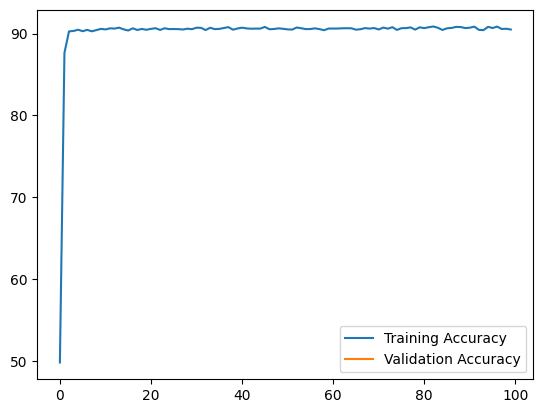

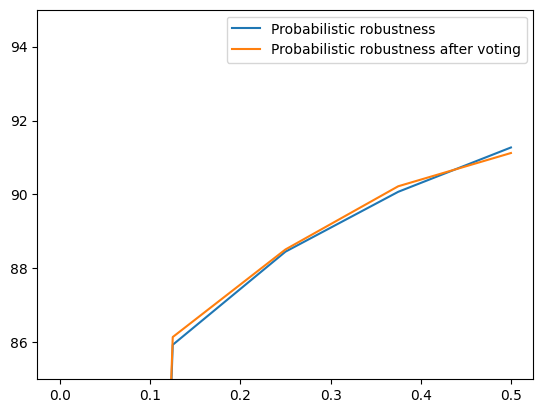

In [7]:
import matplotlib.pyplot as plt

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 100
for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0
    correct = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # ERM
        # outputs = model(X_batch)

        # PRL training
        # x_ = X_batch.repeat(20, 1, 1)
        # ub = X_batch + epsilon
        # lb = X_batch - epsilon
        # x_ = (ub - lb) * torch.rand_like(x_) + lb
        # x_ = torch.cat((X_batch.repeat(1, 1, 1), x_), dim = 0)

        # loss_ = F.binary_cross_entropy(model(x_).squeeze(2), y_batch.repeat(1, 21).T, reduction = 'none')
        # alpha = torch.quantile(loss_.detach(), 1-0.5, dim = 1)
        # loss = F.relu(loss_ - alpha.unsqueeze(1)).mean(dim = 1).sum() / 0.5

        # DA training
        outputs = model(X_batch + (torch.rand_like(X_batch) * 2 - 1) * epsilon)

        # RS training
        # outputs = model(X_batch + torch.randn_like(X_batch) * epsilon)

        loss = criterion(outputs, y_batch)

        if epoch > 0:
            loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.round() == y_batch).float().sum()
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100 * correct.item() / len(train_loader.dataset))


# Plot Accuracy
# plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()
# plt.plot(robustness, label='Validation Probabilistic Robustness')
# plt.plot(robustness_vote, label='Validation Probabilistic Robustness with Voting')


# Validation
model.eval()
val_loss = 0
correct = 0
with torch.no_grad():
    X_test, y_test = X_test.to(device), y_test.to(device)
    val_outputs = model(X_test)
    val_loss = criterion(val_outputs, y_test).item()
    val_losses.append(val_loss)
    correct = (val_outputs.round() == y_test).float().sum()
    val_accuracies.append(100 * correct.item() / len(X_test))

    x_ = X_test.repeat(100, 1, 1)
    ub = X_test + epsilon
    lb = X_test - epsilon
    x_ = (ub - lb) * torch.rand_like(x_) + lb
    x_ = torch.cat((X_test.repeat(1, 1, 1), x_), dim = 0)

    x__ = x_.repeat(305, 1, 1, 1)
    ub = x__ + epsilon
    lb = x__ - epsilon
    x__ = (ub - lb) * torch.rand_like(x__) + lb

    val_outputs__ = model(x__).squeeze(3).round().mean(0)

    robustness, robustness_vote = [], []
    for kappa in np.linspace(0, 0.5, 5):


        val_outputs_ = model(x_).squeeze(2)
        correct_ = (val_outputs_.round()[1:] == y_test.repeat(1, 100).T).float().mean(dim = 0)
        robustness.append(100 * ((correct_ > 1-kappa) & (val_outputs_[0].round().squeeze() == y_test.squeeze()).squeeze()).sum().item()  / len(X_test))

        correct__ = (val_outputs__.round()[1:] == y_test.repeat(1, 100).T).float().mean(dim = 0)
        robustness_vote.append(100 * ((correct__ > 1-kappa) & (val_outputs__[0].round() == y_test.squeeze()).squeeze()).sum().item()  / len(X_test))



    # print(epsilon, kappa, f'Training and Validation Accuracy\nFinal Train: {train_accuracies[-1]:.2f}%, Val: {val_accuracies[-1]:.2f}%, Rob: {robustness[-1]:.2f}%, Vote: {robustness_vote[-1]:.2f}%')

    # plt.title(f'Training and Validation Accuracy\nFinal Train: {train_accuracies[-1]:.2f}%, Val: {val_accuracies[-1]:.2f}%, Rob: {robustness[-1]:.2f}%, Vote: {robustness_vote[-1]:.2f}%')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy (%)')
    # plt.legend()
    plt.plot(np.linspace(0, 0.5, 5), robustness, label='Probabilistic robustness')
    plt.plot(np.linspace(0, 0.5, 5), robustness_vote, label='Probabilistic robustness after voting')
    plt.ylim(85, 95)
    plt.legend()
    plt.show()


In [8]:

# plt.plot(np.linspace(0, 0.5, 50), robustness_vote)